In [1]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REMOVE_DUPLICATE_EEG_IDS = True # if True, each row in training corresponds to a unique eeg_id
AVERAGE_TARGETS_OVER_EEG = True
MAX_ROWS = None # use only MAX_ROWS rows of train.csv, set to None to use all rows
USE_CACHE = True # stores all accessed eeg and spectrogram files in memory
N_EPOCHS = 4

DATA_DIR = 'data' # /kaggle/input/hms-harmful-brain-activity-classification/

keras.utils.set_random_seed(42)

2024-03-07 15:39:21.601475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 15:39:21.601529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 15:39:21.621425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 15:39:21.671594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 15:39:22.320098: W tensorflow/compiler/tf2

In [2]:
train_csv = pd.read_csv(f'{DATA_DIR}/train.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
TARGETS = train_csv.columns[-6:]

def actual_median(s):
    return s.iloc[(s - s.median()).abs().argsort().iloc[0]]

if REMOVE_DUPLICATE_EEG_IDS:
    df_unique_eeg = train_csv.groupby('eeg_id')[['eeg_label_offset_seconds']].agg(actual_median)
    train_df = pd.merge(df_unique_eeg, train_csv, on=['eeg_id', 'eeg_label_offset_seconds'], how='left')
    
    if AVERAGE_TARGETS_OVER_EEG:
        y = train_csv.groupby('eeg_id')[TARGETS].agg('sum')
        y = y.div(y.sum(axis=1), axis=0)
        train_df[TARGETS] = y[TARGETS].values
else:
    train_df = train_csv

train_df = train_df[:MAX_ROWS]

train_df

,eeg_id,eeg_label_offset_seconds,eeg_sub_id,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,6,1,789577333,1,6,3640441665,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,18,5,1552638400,5,18,1179854295,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,0,0,14960202,12,1008,3254468733,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,0,0,618728447,4,908,2898467035,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,0,0,52296320,0,0,3255875127,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0,1188113564,0,0,447244163,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,0,0,1549502620,0,0,1618953053,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,0,0,2105480289,0,0,469526364,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,6,2,657299228,2,6,3251917981,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [3]:
if USE_CACHE:
    spg_cache = {}
    spg_cache_file = f'{DATA_DIR}/cache/spg_cache.npy'
    if os.path.exists(spg_cache_file):
        spg_cache = np.load(spg_cache_file, allow_pickle=True).item()

def read_spg(spg_id, train=True):
    if USE_CACHE and spg_id in spg_cache:
        return spg_cache[spg_id]
    else:
        if train:
            spg = pd.read_parquet(f'{DATA_DIR}/train_spectrograms/{spg_id}.parquet')
            if USE_CACHE:
                spg_cache[spg_id] = spg
        else:
            spg = pd.read_parquet(f'{DATA_DIR}/test_spectrograms/{spg_id}.parquet')
        return spg

def spg_window(row, train=True):
    spg_data = read_spg(row.spectrogram_id, train)
    if train:
        spg_offset = int(row.spectrogram_label_offset_seconds)
        spg_data = spg_data.loc[(spg_data.time >= spg_offset) & (spg_data.time < spg_offset + 600)]
        spg_data = spg_data.drop(columns=['time'])
    return spg_data

In [9]:
import librosa

IMAGE_HEIGHT = 100  # 100 frequency bands
IMAGE_WIDTH = 300

EEG_N_MELS = 100  # 100 frequency bands
EEG_FREQ = 200  # fixed
EEG_HOP_LENGTH = 40
EEG_SPG_FREQ = EEG_FREQ // EEG_HOP_LENGTH

SPG_WIDTH = 600 // 2  # 600 seconds / 2 seconds per sample => 300 samples
EEG_SPG_WIDTH = 50 * EEG_FREQ // EEG_HOP_LENGTH  # 50 seconds * 200 samples per second => 10000 EEG samples => 10000 / EEG_HOP_LENGTH EEG_SPG samples

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def eeg_to_spg(eeg, n_mels=EEG_N_MELS, display=False):
    hop_length = EEG_HOP_LENGTH  # window hop/shift step size: 50 / 200 = 0.25s
    win_length = 2 * hop_length  # window size: 0.5s
    n_windows = len(eeg) // hop_length  # number of windows

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((n_mels, n_windows, 4), dtype='float32')
    
    for i in range(4):
        COLS = FEATS[i]
        for j in range(4):  # 5 columns
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[j]].values - eeg[COLS[j + 1]].values

            # FILL NANS
            x = np.nan_to_num(x, nan=0.0)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=EEG_FREQ, hop_length=hop_length,
                  n_fft=1024, n_mels=n_mels, fmin=0, fmax=20, win_length=win_length)
            
            # LOG TRANSFORM
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)

            img[:, :, i] += 0.25 * mel_spec_db[:, :n_windows]
            
        if display:
            plt.subplot(2, 2, i + 1)
            plt.imshow(img[:, :, i], aspect='auto', origin='lower')
    
    return img

if USE_CACHE:
    eeg_spg_cache = {}
    eeg_spg_cache_file = f'{DATA_DIR}/cache/eeg_spg_cache.npy'
    if os.path.exists(eeg_spg_cache_file):
        eeg_spg_cache = np.load(eeg_spg_cache_file, allow_pickle=True).item()

def eeg_id_to_spg(eeg_id, train=True):
    if USE_CACHE and eeg_id in eeg_spg_cache:
        return eeg_spg_cache[eeg_id]
    else:
        if train:
            eeg_spg = eeg_to_spg(pd.read_parquet(f'{DATA_DIR}/train_eegs/{eeg_id}.parquet'))
            if USE_CACHE:
                eeg_spg_cache[eeg_id] = eeg_spg
        else:
            eeg_spg = eeg_to_spg(pd.read_parquet(f'{DATA_DIR}/test_eegs/{eeg_id}.parquet'))
        return eeg_spg


def eeg_spg_window(row, train=True):
    img = eeg_id_to_spg(row.eeg_id, train)
    if train:
        eeg_offset = int(row.eeg_label_offset_seconds)
        img = img[:, (EEG_SPG_FREQ * eeg_offset):(EEG_SPG_FREQ * (eeg_offset + 50))]
    
    # standardize by channel:
    img = img - img.mean(axis=(0, 1))
    img = img / (img.std(axis=(0, 1)) + 1e-6)
    img = np.pad(img, pad_width=[(0, 0), (0, 50 * EEG_SPG_FREQ - img.shape[1]), (0, 0)])
    return img


# spg_from_eeg(eeg_window(train_df.iloc[0]), display=True).shape
eeg_spg_window(train_df.iloc[0]).shape

[-37.242344 -35.953934 -37.704556 -38.214176]
[ 7.4661257e-05 -6.0354614e-06 -7.3663025e-05  5.6126405e-06]
[12.167962  11.651404  13.457943  12.1740885]
[1.000001  1.0000021 1.0000015 0.9999996]


(100, 250, 4)

In [17]:
import albumentations as albu

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, train=True, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mix_candidate_by_class = [None] * 6
        self.train = train
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        m, r = divmod(len(self.data), self.batch_size)
        return m + (1 if r > 0 else 0)

    def __getitem__(self, i):
        """Generate one batch of data"""
        indices = self.indices[(i * self.batch_size):((i + 1) * self.batch_size)]
        X, y = self.__data_generation(indices)
        if self.augment and self.train:
            X = self.__augment_batch(X, y) 
        return X, y
    
    def __data_generation(self, indices):
        spg_window_left = max(0, (IMAGE_WIDTH - SPG_WIDTH) // 2)
        spg_window_right = min(IMAGE_WIDTH, spg_window_left + SPG_WIDTH)
        eeg_window_left = max(0, (IMAGE_WIDTH - EEG_SPG_WIDTH) // 2)
        eeg_window_right = min(IMAGE_WIDTH, eeg_window_left + EEG_SPG_WIDTH)
        X = np.zeros((len(indices), IMAGE_HEIGHT, IMAGE_WIDTH, 8), dtype='float32')
        y = np.zeros((len(indices), 6), dtype='float32')

        for i_batch, i_row in enumerate(indices):
            row = self.data.iloc[i_row]

            spg = spg_window(row, train=self.train).values.T

            for j in range(4):
                img = spg[(j * 100):((j + 1) * 100), :]
                
                img = np.nan_to_num(img, nan=0.0)
                
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                img = img - img.mean()
                img = img / (img.std() + 1e-6)
                
                X[i_batch, :, spg_window_left:spg_window_right, j] = img[:, :]

            img = eeg_spg_window(row, train=self.train)
            X[i_batch, :, eeg_window_left:eeg_window_right, 4:] = img[:, :]

            if self.train:
                y[i_batch, :] = row[TARGETS]

        return X, y
    
    def __mix_in_class(self, img, cls, mix_size=(50, 75), p=0.5, p_replace=0.5):
        low, high = mix_size
        mix_size = np.random.randint(low=low, high=high)

        mix_candidate = self.mix_candidate_by_class[cls]
        if mix_candidate is None:
            self.mix_candidate_by_class[cls] = img
            return img
        
        if np.random.uniform() < p:
            mixed_img = mix_candidate.copy()
            mixed_img[:, mix_size:-mix_size, :] = img[:, mix_size:-mix_size, :]
        else:
            mixed_img = img
        
        if np.random.uniform() < p_replace:
            self.mix_candidate_by_class[cls] = img

        return mixed_img


    def __random_transform(self, img, cls):
        # img = self.__mix_in_class(img, cls, mix_size=(20, 75), p=0.5, p_replace=0.75)
        composition = albu.Compose([
            albu.XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=60, mask_y_length=10, p=0.5)
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, X_batch, y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ] = self.__random_transform(X_batch[i, ], np.argmax(y_batch[i, ]))
        return X_batch

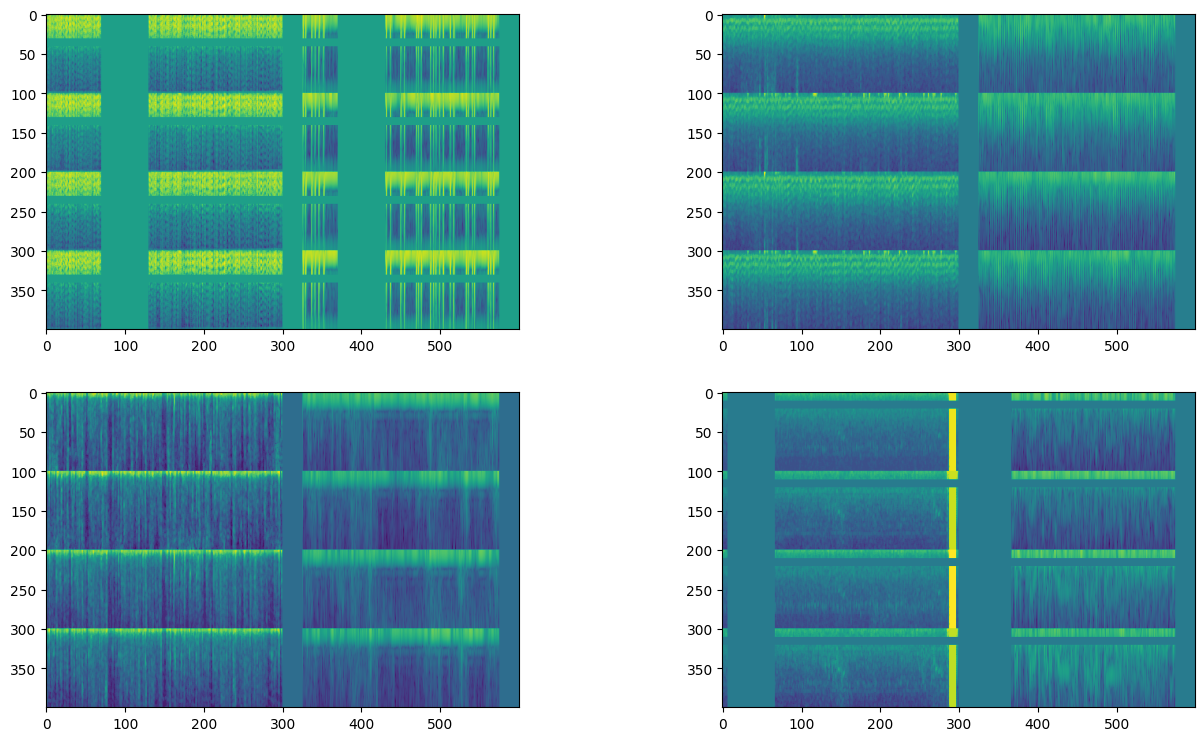

In [18]:
gen = DataGenerator(train_df, shuffle=True, augment=True)

ROWS = 2
COLS = 2
BATCHES = 1

for i, (X, y) in enumerate(gen):
    plt.figure(figsize=(16, 9))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            t = y[j * COLS + k]
            img_spg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4)], axis=0)
            img_eeg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4, 8)], axis=0)
            img = np.concatenate([img_spg, img_eeg], axis=1)
            plt.imshow(img)
    plt.show()
    if i == BATCHES - 1:
        break

In [19]:
def build_model():
    base_model = keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)
    # base_model = keras_cv.models.ImageClassifier.from_preset('efficientnetv2_b0_imagenet', num_classes=6)

    inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 8))

    x1 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4)])
    x2 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4, 8)])
    x = keras.layers.Concatenate(axis=2)([x1, x2])
    x = keras.layers.Concatenate(axis=3)([x, x, x])

    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss=keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

    return model

def lr_scheduler(epoch, lr):
    r = [1, 1, 0.1, 0.1, 0.5]
    return lr * r[epoch]
callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [20]:
from sklearn.model_selection import GroupKFold

out_of_folds_predicts = []
out_of_folds_labels = []

group_k_fold = GroupKFold(n_splits=5)
for i, (train_indices, valid_indices) in enumerate(group_k_fold.split(train_df, groups=train_df.patient_id)):
    print(f'{"_" * 30} Fold {i + 1} {"_" * 30}')

    train_data_gen = DataGenerator(train_df.iloc[train_indices], shuffle=True, augment=True)
    valid_data_gen = DataGenerator(train_df.iloc[valid_indices], shuffle=False, batch_size=64)

    model = build_model()
    model.fit(train_data_gen, validation_data=valid_data_gen, epochs=N_EPOCHS, callbacks=[callback], verbose=1)
    model.save_weights(f'model_en0_v2_f{i}.weights.h5')

    out_of_folds_predicts.append(model.predict(valid_data_gen))
    out_of_folds_labels.append(train_df.iloc[valid_indices][TARGETS].values)

out_of_folds_predicts = np.concatenate(out_of_folds_predicts)
out_of_folds_labels = np.concatenate(out_of_folds_labels)

______________________________ Fold 1 ______________________________
Epoch 1/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 130s 197ms/step - loss: 0.8456 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 2/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 59s 137ms/step - loss: 0.5772 - val_loss: 0.9521 - learning_rate: 0.0010
Epoch 3/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 60s 139ms/step - loss: 0.4569 - val_loss: 0.6019 - learning_rate: 1.0000e-04
Epoch 4/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 60s 139ms/step - loss: 0.3928 - val_loss: 0.6057 - learning_rate: 1.0000e-05
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step
______________________________ Fold 2 ______________________________
Epoch 1/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 131s 192ms/step - loss: 0.8415 - val_loss: 1.7664 - learning_rate: 0.0010
Epoch 2/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 62s 143ms/step - loss: 0.5603 - val_loss: 0.8397 - learning_rate: 0.0010
Epoch 3/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - loss: 0.4690 - val_loss: 0.5911 - learning_rate: 1.0000e-04
Epoch 4/4
428/428 ━━━━

In [21]:
# import sys
# sys.path.append('/kaggle/input/kaggle-kl-div')

from kaggle_kl_div import score

out_of_folds_predicts_df = pd.DataFrame(out_of_folds_predicts.copy())
out_of_folds_predicts_df['id'] = np.arange(len(out_of_folds_predicts))

out_of_folds_labels_df = pd.DataFrame(out_of_folds_labels.copy())
out_of_folds_labels_df['id'] = np.arange(len(out_of_folds_labels))

score(solution=out_of_folds_labels_df, submission=out_of_folds_predicts_df, row_id_column_name='id')

0.5711857208273363

In [22]:
# np.save(spg_cache_file, spg_cache, allow_pickle=True)
# np.save(eeg_spg_cache_file, eeg_spg_cache, allow_pickle=True)

| CV | N_EPOCHS | augment | HOP_LENGTH | IMAGE_WIDTH |
|---|---|---|---|---|
| 0.5718070311429861 / 0.5720780018687583 / 0.5810115025393138 | 4 | False | 40 | 300 |
| 0.5757338634039837 | 4 | XYMasking(num_masks_x=(1, 3), num_masks_y=(1, 3), mask_x_length=(15, 30), mask_y_length=(5, 10), p=0.5) | 40 | 300 |
| 0.5787746552492183 | 4 | XYMasking(num_masks_x=(1, 2), num_masks_y=(1, 2), mask_x_length=30, mask_y_length=10, p=0.5) | 40 | 300 |
| 0.586470413477034 | 4 | XYMasking(num_masks_x=3, num_masks_y=3, mask_x_length=30, mask_y_length=10, p=0.5) | 40 | 300 |
| 0.5828748926634817 | 4 | XYMasking(num_masks_x=2, num_masks_y=2, mask_x_length=15, mask_y_length=5, p=0.5) | 40 | 300 |
| 0.5808692308780142 | 4 | XYMasking(num_masks_x=2, num_masks_y=2, mask_x_length=30, mask_y_length=10, p=0.5) | 40 | 300 |
| 0.5790057917827615 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=60, mask_y_length=20, p=0.5) | 40 | 300 |
| 0.574837725632903 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=75, mask_y_length=10, p=0.5) | 40 | 300 |
| 0.5728450436416965 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=30, mask_y_length=10, p=0.5) | 40 | 300 |
| 0.568596255238429 / 0.5715593023654647 / 0.5711857208273363 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=60, mask_y_length=10, p=0.5) | 40 | 300 |


In [23]:
test_df = pd.read_csv(f'{DATA_DIR}/test.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
test_data_gen = DataGenerator(test_df, train=False)

predicts = []
model = build_model()
for i in range(5):
    print(f'{"_" * 30} Fold {i + 1} {"_" * 30}')
    model.load_weights(f'model_en0_v2_f{i}.weights.h5')
    predict = model.predict(test_data_gen, verbose=1)
    predicts.append(predict)
predicts = np.mean(predicts, axis=0)
predicts

______________________________ Fold 1 ______________________________


/home/rli/src/hms-harmful-brain-activity-classification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
______________________________ Fold 2 ______________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/rli/src/hms-harmful-brain-activity-classification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


______________________________ Fold 3 ______________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/rli/src/hms-harmful-brain-activity-classification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


______________________________ Fold 4 ______________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/home/rli/src/hms-harmful-brain-activity-classification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


______________________________ Fold 5 ______________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/rli/src/hms-harmful-brain-activity-classification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 428 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


array([[0., 0., 0., 0., 0., 1.]], dtype=float32)

In [24]:
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
sub[TARGETS] = predicts
sub.to_csv('submission.csv',index=False)
print('Submissionn shape', sub.shape)
sub

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.0,0.0,0.0,0.0,0.0,1.0


| CV | N_EPOCHS | augment | HOP_LENGTH | IMAGE_WIDTH |
|---|---|---|---|---|
| 0.5878570498295667 | 4 | False | 50 | 200 |
| 0.6043616237737167 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=(40, 20), mask_y_length=(20, 10), p=1) | 50 | 200 |
| 0.5985598798264276 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 10], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.588225632626801 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(2, 5), p=0.5) | 50 | 200 |
| 0.5873564400750843 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(2, 4), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.587237356938107 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 2], mask_x_length=(10, 20), mask_y_length=(5, 10), p=1) | 50 | 200 |
| 0.5856693916188898 | 4 | XYMasking(num_masks_x=[1, 10], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.5820978655018046 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 2], mask_x_length=(10, 20), mask_y_length=(5, 10), p=0.5) | 50 | 200 |
| 0.5816122349523126 | 4 | XYMasking(num_masks_x=[1, 2], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
| 0.5790920109940367 / 0.5885298827570618 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 50 | 200 |
||
| 0.601376578704538 | 4 | __mix_in_class(img, cls, mix_size=(25, 50), p=0.5, p_replace=0.5) | 50 | 200 |
| 0.6035723289798931 | 4 | __mix_in_class(img, cls, mix_size=(50, 75), p=0.5, p_replace=0.5) | 50 | 200 |
| 0.6067157104474956 | 4 | __mix_in_class(img, cls, mix_size=(10, 20), p=0.5, p_replace=0.5) | 50 | 200 |
| 0.597614967877042 | 4 | __mix_in_class(img, cls, mix_size=(5, 100), p=0.5, p_replace=0.5) | 50 | 200 |
| 0.5999506166084912 | 4 | __mix_in_class(img, cls, mix_size=(20, 50), p=0.5, p_replace=0.5) | 50 | 200 |
| 0.5856536078659322 | 4 | __mix_in_class(img, cls, mix_size=(20, 75), p=0.5, p_replace=0.75) | 50 | 200 |
| 0.5900498203849935 | 4 | __mix_in_class(img, cls, mix_size=(20, 75), p=0.5, p_replace=1) | 50 | 200 |
| 0.5984095396369125 | 4 | __mix_in_class(img, cls, mix_size=(20, 75), p=0.5, p_replace=0.9) | 50 | 200 |

| CV | N_EPOCHS | augment | HOP_LENGTH | IMAGE_WIDTH |
|---|---|---|---|---|
| 0.5716192089250065 | 4 | False | 40 | 300 |
| 0.5784534153861591 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=(75, 150), mask_y_length=(25, 50), p=0.5) | 40 | 300 |
| 0.5776818966858787 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 30), mask_y_length=(2, 10), p=0.5) | 40 | 300 |
| 0.5766340693490476 | 4 | XYMasking(num_masks_x=(1, 5), num_masks_y=(1, 5), mask_x_length=(5, 15), mask_y_length=(2, 5), p=0.5) | 40 | 300 |
| 0.5739432918327704 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(2, 5), p=0.5) | 40 | 300 |
| 0.5714134643405246 | 4 | XYMasking(num_masks_x=(1, 3), num_masks_y=(1, 3), mask_x_length=(15, 30), mask_y_length=(5, 10), p=0.5) | 40 | 300 |
| 0.5713614548348664 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=(30, 75), mask_y_length=(10, 25), p=0.5) | 40 | 300 |
| 0.570796338532459 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(1, 2), p=0.5) | 40 | 300 |
| 0.570397588674275 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(5, 10), mask_y_length=(2, 10), p=0.5) | 40 | 300 |
| 0.5702277227046777 | 4 | XYMasking(num_masks_x=[1, 5], num_masks_y=[1, 5], mask_x_length=(15, 30), mask_y_length=(1, 2), p=0.5) | 40 | 300 |
| 0.5703380188104641 | 4 | XYMasking(num_masks_x=1, num_masks_y=1, mask_x_length=(25, 75), mask_y_length=(5, 20), p=0.5) | 40 | 300 |